# Plant pathology 2020

EfficientNet Implimentation on the Plant Pathology 2020 competition on Kaggle.  

Credits : https://www.kaggle.com/skeef79/plant-pathology-2020-efficientnetb7-0-980-score

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf, tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from kaggle_datasets import KaggleDatasets

 **TPU preparation**

In [2]:
AUTO = tf.data.experimental.AUTOTUNE
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

GCS_DS_PATH = KaggleDatasets().get_gcs_path()

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


**Important constants**

In [3]:
IMG_SIZE = 784
BATCH_SIZE = 8*strategy.num_replicas_in_sync
nb_classes = 4

**Loading data**

In [4]:
path='../input/plant-pathology-2020-fgvc7/'

train = pd.read_csv(path+'train.csv')
train_id = train['image_id']
train.pop('image_id')

y_train = train.to_numpy().astype('float32')
category_names = ['healthy','multiple_diseases','rust','scab']

root = 'images'
images_paths = [(os.path.join(GCS_DS_PATH,root,idee+'.jpg')) for idee in train_id]

**Split data into train and validation set**

In [5]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val = train_test_split(images_paths,y_train,test_size=0.2,shuffle=True)

**Class weights**

Dataset is not balanced, so we need to use class_weights. 

class weights:  [0.875      5.05555556 0.7413442  0.76310273]


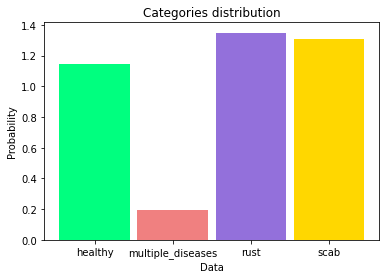

In [6]:

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced',np.unique(y_train.argmax(axis=1)),y_train.argmax(axis=1))
print('class weights: ',class_weights)

plt.bar(range(4),1/class_weights,color=['springgreen', 'lightcoral', 'mediumpurple', 'gold'],width=0.9)
plt.xticks(range(4), category_names) 

plt.title("Categories distribution");
plt.ylabel('Probability')
plt.xlabel('Data')
plt.show()

#class weights to dict
c_w = dict(zip(range(4),class_weights))

functions to image preprocessing

In [7]:
def decode_image(filename, label=None, image_size=(IMG_SIZE, IMG_SIZE)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    
    #convert to numpy and do some cv2 staff mb?
    
    if label is None:
        return image
    else:
        return image, label

def data_augment(image, label=None, seed=5050):
    image = tf.image.random_flip_left_right(image, seed=seed)
    image = tf.image.random_flip_up_down(image, seed=seed)
           
    if label is None:
        return image
    else:
        return image, label

**Preparing train and validation sets**

In [8]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
    )

In [9]:
val_dataset = (tf.data.Dataset
               .from_tensor_slices((x_val,y_val))
               .map(decode_image,num_parallel_calls=AUTO)
               .batch(BATCH_SIZE)
               .cache()
               .prefetch(AUTO)
              )

In [10]:
!pip install efficientnet
import efficientnet.tfkeras as efn
import tensorflow as tf, tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers

**Model architecture**

In [11]:
def get_model():
    base_model = efn.EfficientNetB7(weights='imagenet',
                          include_top=False,
                          input_shape=(IMG_SIZE,IMG_SIZE, 3),
                          pooling='avg')
    x = base_model.output
    predictions = Dense(nb_classes, activation="softmax")(x)
    return Model(inputs=base_model.input, outputs=predictions)

In [12]:
from tensorflow.keras.optimizers import Adam

with strategy.scope():
    model = get_model()

opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

258441216/258434480 [==============================] - 22s 0us/step


**callbacks**

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

model_name = 'effNetPlants.h5'

#good callbacks
best_model = ModelCheckpoint(model_name, monitor='val_loss', verbose=1, save_best_only=True,save_weights_only=True,mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.5,verbose=1,min_lr=0.000001,patience=6)

In [14]:
history = model.fit(train_dataset,
                    steps_per_epoch=y_train.shape[0]//BATCH_SIZE,
                    epochs=50,
                    verbose=1,
                    validation_data=val_dataset,
                    callbacks=[reduce_lr,best_model]
                    )

Train for 22 steps, validate for 6 steps
Epoch 1/50
21/22 [===========================>..] - ETA: 16s - loss: 0.6919 - accuracy: 0.7560
Epoch 00001: val_loss improved from inf to 2.40521, saving model to effNetPlants.h5
22/22 [==============================] - 395s 18s/step - loss: 0.6889 - accuracy: 0.7557 - val_loss: 2.4052 - val_accuracy: 0.7174
Epoch 2/50
21/22 [===========================>..] - ETA: 1s - loss: 0.4225 - accuracy: 0.9107
Epoch 00002: val_loss improved from 2.40521 to 1.14818, saving model to effNetPlants.h5
22/22 [==============================] - 31s 1s/step - loss: 0.4146 - accuracy: 0.9091 - val_loss: 1.1482 - val_accuracy: 0.8261
Epoch 3/50
21/22 [===========================>..] - ETA: 1s - loss: 0.2741 - accuracy: 0.9286
Epoch 00003: val_loss improved from 1.14818 to 0.50945, saving model to effNetPlants.h5
22/22 [==============================] - 31s 1s/step - loss: 0.2799 - accuracy: 0.9318 - val_loss: 0.5094 - val_accuracy: 0.9130
Epoch 4/50
21/22 [=========

Epoch 29/50
21/22 [===========================>..] - ETA: 1s - loss: 0.0087 - accuracy: 0.9940
Epoch 00029: val_loss did not improve from 0.14935
22/22 [==============================] - 30s 1s/step - loss: 0.0085 - accuracy: 0.9943 - val_loss: 0.2200 - val_accuracy: 0.9565
Epoch 30/50
21/22 [===========================>..] - ETA: 1s - loss: 0.0089 - accuracy: 0.9940
Epoch 00030: val_loss did not improve from 0.14935
22/22 [==============================] - 30s 1s/step - loss: 0.0085 - accuracy: 0.9943 - val_loss: 0.1981 - val_accuracy: 0.9565
Epoch 31/50
21/22 [===========================>..] - ETA: 1s - loss: 0.0080 - accuracy: 1.0000
Epoch 00031: val_loss did not improve from 0.14935
22/22 [==============================] - 30s 1s/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.2025 - val_accuracy: 0.9565
Epoch 32/50
21/22 [===========================>..] - ETA: 1s - loss: 0.0053 - accuracy: 1.0000
Epoch 00032: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.



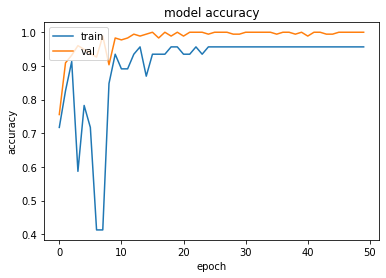

In [15]:
plt.title('model accuracy')
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
path='../input/plant-pathology-2020-fgvc7/'

test = pd.read_csv(path+'test.csv')
test_id = test['image_id']

root = 'images'
x_test = [(os.path.join(GCS_DS_PATH,root,idee+'.jpg')) for idee in test_id]

In [17]:
model.load_weights(model_name)

In [18]:
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

In [19]:
y_pred = model.predict(test_dataset,verbose=1)

29/29 [==============================] - 130s 4s/step


In [20]:
def save_results(y_pred):
    
    path='../input/plant-pathology-2020-fgvc7/'
    test = pd.read_csv(path + 'test.csv')
    test_id = test['image_id']

    res = pd.read_csv(path+'train.csv')
    res['image_id'] = test_id
  
    labels = res.keys()

    for i in range(1,5):
        res[labels[i]] = y_pred[:,i-1]

    res.to_csv('submission.csv',index=False)
  
    print(res.head)

In [21]:
save_results(y_pred)

<bound method NDFrame.head of        image_id       healthy  multiple_diseases      rust          scab
0        Test_0  1.019013e-05       8.168368e-04  0.999106  6.689032e-05
1        Test_1  2.086389e-07       5.216537e-05  0.999943  5.182418e-06
2        Test_2  2.020897e-05       2.551105e-04  0.000058  9.996665e-01
3        Test_3  9.999657e-01       3.096806e-08  0.000034  4.966426e-07
4        Test_4  3.669747e-07       3.213140e-05  0.999962  5.215013e-06
...         ...           ...                ...       ...           ...
1816  Test_1816  2.003406e-08       4.850098e-05  0.999949  2.154552e-06
1817  Test_1817  2.710807e-06       1.209226e-03  0.000070  9.987183e-01
1818  Test_1818  3.068051e-06       1.333295e-04  0.999858  5.407192e-06
1819  Test_1819  9.999406e-01       4.341968e-05  0.000012  4.286160e-06
1820  Test_1820  8.649089e-05       2.862977e-03  0.000020  9.970304e-01

[1821 rows x 5 columns]>
